# House Cost Estimation ML Project

In this project, I'll go through the whole process of EDA + Model training to build a ML model that would predict the cost of house in Bengaluru based on some features like area, rooms, etc.

## <span style='color:lightgreen'>Part 1 : Data Cleaning</span>

### Import Libraries
I will import some libraries necessary for this part

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Import CSV File (Dataset)

In [3]:
df1 = pd.read_csv('Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df1.shape

(13320, 9)

In [5]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

### Drop unnecessary Columns

In [7]:
df1_dropped = df1.drop(['availability', 'society', 'balcony', 'area_type'], axis=1)
df1_dropped.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


### Check for NA Values in columns

In [8]:
df1_dropped.isnull().any()

location       True
size           True
total_sqft    False
bath           True
price         False
dtype: bool

In [9]:
df1_dropped.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
df2 = df1_dropped.dropna()
df2.isnull().any()

location      False
size          False
total_sqft    False
bath          False
price         False
dtype: bool

In [11]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [12]:
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))

In [13]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [14]:
df2['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

### Find dirty values
There are a lot of dirty values in ['total_sqft'] column like
- 2100 - 2850         <span style='color:lightgreen'># Range</span>
- 3.46Sq. Meter       <span style='color:lightgreen'># Diff. unit</span>
- 4125Perch           <span style='color:lightgreen'># Diff. unit</span>

This shows the data is unstructured, thus we need to find these values and modify them 

In [15]:
def is_float(x):
    '''
    Checks if the value is float or not (then it can be in any other unit [mentioned above])
    '''
    try:
        float(x)
    except:
        return False
    return True

Here, the **~** will give all rows of DF that satisfy the requirements

In [16]:
df2[~df2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [17]:
def sqft_range_to_num(x : str) -> float:
    '''
    Splits the string range, checks if there are 2 areas, then finds their avg. 
    If not 2 areas but one string value (normal area values), then just converts to float.
    '''
    tokens = x.split(' - ')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

In [18]:
sqft_range_to_num('2100 - 2850')

2475.0

In [19]:
# make a copy for easier use
df3 = df2.copy()

In [20]:
df3['total_sqft'] = df3['total_sqft'].apply(sqft_range_to_num)
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [21]:
df3.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

## <span style='color:lightgreen'>Part 2 : Feature Engineering</span>

In this part, I'm going to check the features, if there are unnecessary features or there are some ways by which we could shorten the Dataframe

In [22]:
df4 = df3.copy()

In [23]:
# Make a new column for 'price_per_sqft'. This will help me later
df4['price_per_sqft'] = (df4['price']*100000) / df4['total_sqft']

In [24]:
df4.location = df4.location.apply(lambda x : x.strip())

In [25]:
location_stats = df4['location'].value_counts()
location_stats

location
Whitefield                        535
Sarjapur  Road                    392
Electronic City                   304
Kanakpura Road                    266
Thanisandra                       236
                                 ... 
Vasantapura main road               1
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Abshot Layout                       1
Name: count, Length: 1293, dtype: int64

In [26]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

location
Naganathapura                     10
Sadashiva Nagar                   10
Nagappa Reddy Layout              10
BTM 1st Stage                     10
Sector 1 HSR Layout               10
                                  ..
Vasantapura main road              1
Bapuji Layout                      1
1st Stage Radha Krishna Layout     1
BEML Layout 5th stage              1
Abshot Layout                      1
Name: count, Length: 1052, dtype: int64

In [27]:
len(location_stats_less_than_10)

1052

In [28]:
df4.location = df4.location.apply(lambda x : 'other' if x in location_stats_less_than_10 else x)

## <span style='color:lightgreen'>Part 3 : Outlier Removal</span>

Talked with the real estate officer, he told that the sqft/no._of_rooms should be >300 (300 is the threshold)

In [29]:
df4[df4.total_sqft/df4['bhk']<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [30]:
df4.shape

(13246, 7)

In [31]:
df6 = df4[~(df4.total_sqft/df4['bhk']<300)]
df6.shape

(12502, 7)

### Example of How the Function Works

Let's go through an example to illustrate this process. Suppose you have the following DataFrame `df`:

| location       | price_per_sqft |
|----------------|----------------|
| New York       | 500            |
| New York       | 510            |
| New York       | 520            |
| New York       | 1000           |
| New York       | 530            |
| New York       | 540            |
| San Francisco  | 800            |
| San Francisco  | 810            |
| San Francisco  | 1500           |
| San Francisco  | 820            |

### Step-by-Step Process:

1. **Initial Data**: 
   - `df_out` starts as an empty DataFrame.
   - The DataFrame `df` contains property listings for "New York" and "San Francisco".

2. **First Iteration (New York)**:
   - `key` = "New York"
   - `sub_df` contains the rows for "New York":

     | location | price_per_sqft |
     |----------|----------------|
     | New York | 500            |
     | New York | 510            |
     | New York | 520            |
     | New York | 1000           |
     | New York | 530            |
     | New York | 540            |

   - Calculate `mean` and `std` for the "New York" `price_per_sqft` values:
     - `mean` ≈ 600
     - `std` ≈ 190
   - Filter rows within the range `[mean - std, mean + std]`:
     - `[600 - 190, 600 + 190]` → `[410, 790]`
   - Filtered `reduced_df` for "New York":

     | location | price_per_sqft |
     |----------|----------------|
     | New York | 500            |
     | New York | 510            |
     | New York | 520            |
     | New York | 530            |
     | New York | 540            |

   - Concatenate `reduced_df` to `df_out`:

     | location | price_per_sqft |
     |----------|----------------|
     | New York | 500            |
     | New York | 510            |
     | New York | 520            |
     | New York | 530            |
     | New York | 540            |

3. **Second Iteration (San Francisco)**:
   - `key` = "San Francisco"
   - `sub_df` contains the rows for "San Francisco":

     | location       | price_per_sqft |
     |----------------|----------------|
     | San Francisco  | 800            |
     | San Francisco  | 810            |
     | San Francisco  | 1500           |
     | San Francisco  | 820            |

   - Calculate `mean` and `std` for "San Francisco":
     - `mean` ≈ 982.5
     - `std` ≈ 312
   - Filter rows within the range `[mean - std, mean + std]`:
     - `[982.5 - 312, 982.5 + 312]` → `[670.5, 1294.5]`
   - Filtered `reduced_df` for "San Francisco":

     | location       | price_per_sqft |
     |----------------|----------------|
     | San Francisco  | 800            |
     | San Francisco  | 810            |
     | San Francisco  | 820            |

   - Concatenate `reduced_df` to `df_out`:

     | location       | price_per_sqft |
     |----------------|----------------|
     | New York       | 500            |
     | New York       | 510            |
     | New York       | 520            |
     | New York       | 530            |
     | New York       | 540            |
     | San Francisco  | 800            |
     | San Francisco  | 810            |
     | San Francisco  | 820            | 500, 700, 750]` where `mean` is 560 and `std` is 130, which values will remain after filtering?


In [32]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, sub_df in df.groupby('location'):
        mean = np.mean(sub_df.price_per_sqft)
        std = np.std(sub_df.price_per_sqft)
        reduced_df = sub_df[(sub_df.price_per_sqft > (mean - std)) & (sub_df.price_per_sqft <= (mean + std))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [33]:
df7 = remove_pps_outliers(df6)
df7.shape
df7.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,10241.000000,10241.000000,10241.000000,10241.000000,10241.000000
mean,1503.877034,2.474075,90.982730,2.572210,5657.702572
std,876.716232,0.981338,86.147549,0.896219,2266.476980
min,300.000000,1.000000,10.000000,1.000000,1250.000000
25%,1108.000000,2.000000,49.000000,2.000000,4244.762955
50%,1282.000000,2.000000,67.000000,2.000000,5172.413793
75%,1650.000000,3.000000,100.000000,3.000000,6426.099852
max,30400.000000,16.000000,2200.000000,16.000000,24509.803922


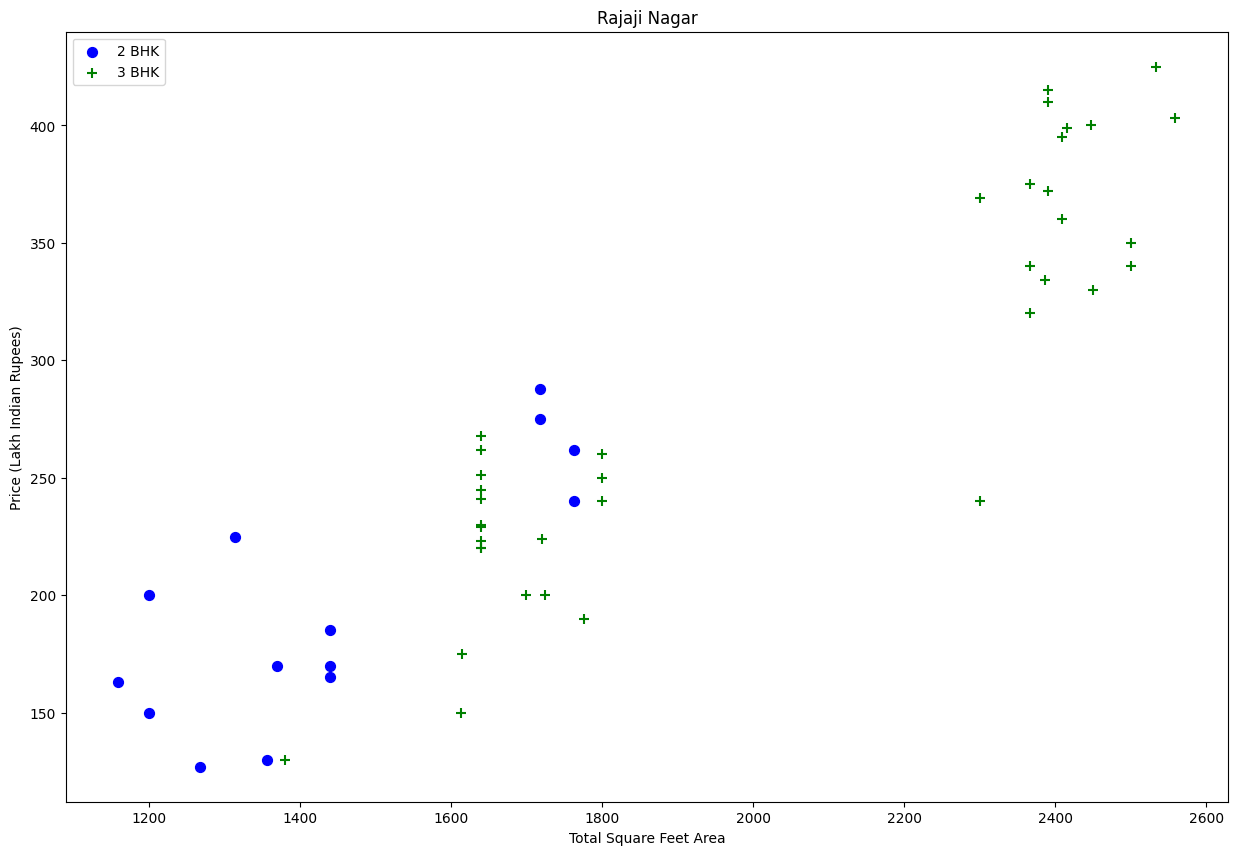

In [34]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()
    
plot_scatter_chart(df7,"Rajaji Nagar")

In [35]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7329, 7)

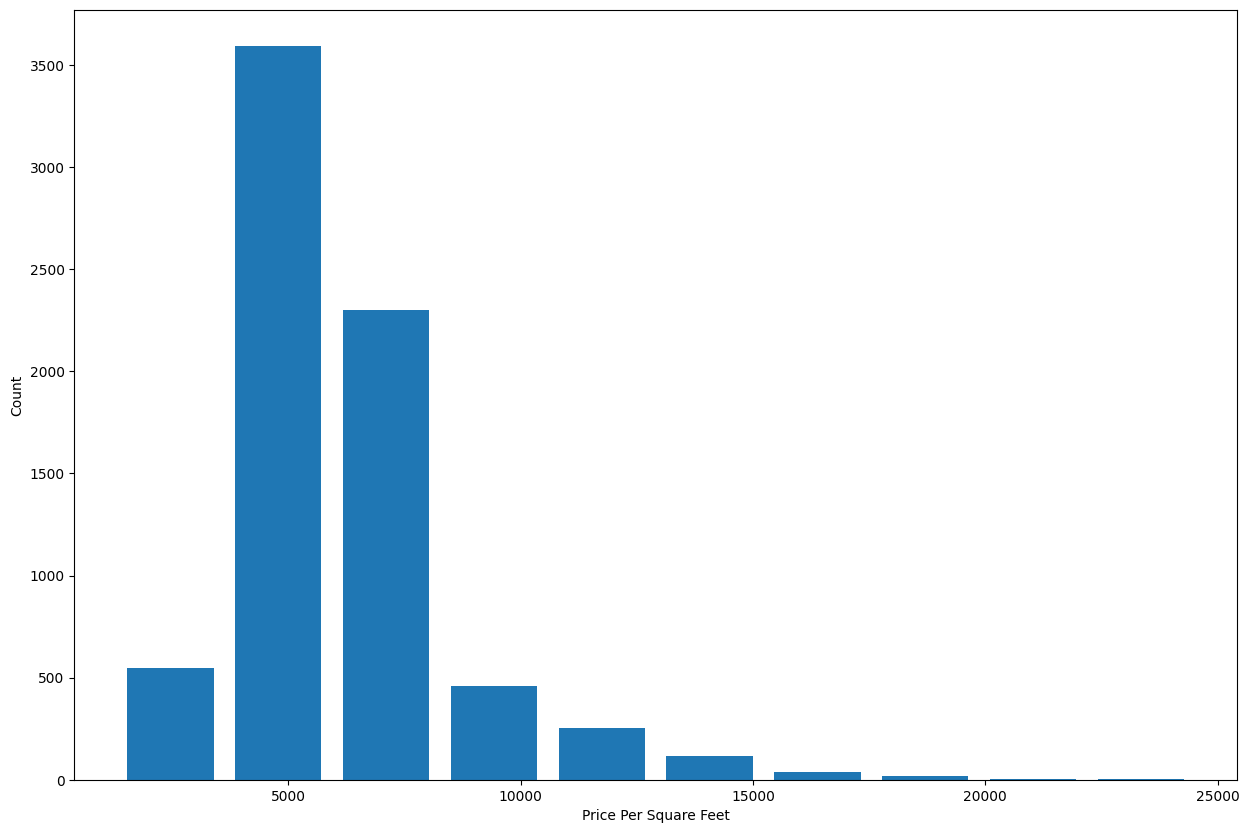

In [36]:
import matplotlib
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

In [37]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [38]:
df8[df8.bath > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


##### The Biz Manager told that we can mark those data points as _outliers_ whose bath no. > bhk+2

In [39]:
df8[df8.bath > (df8.bhk+2)]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [40]:
df9 = df8[df8.bath < (df8.bhk+2)]
df9.shape

(7251, 7)

### Getting Ready for Model Training (Dropping unnecessary cols)

In [41]:
df10 = df9.drop(['size', 'price_per_sqft'], axis=1)
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [42]:
dummies = pd.get_dummies(df10.location, dtype=int)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df11 = pd.concat([df10, dummies.drop('other', axis=1)], axis=1)
df11.head(3)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Removing location column as we have the locations as separate columns
df12 = df11.drop('location', axis=1)

In [45]:
X = df12.drop('price', axis=1)
y = df12.price

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.3)

In [47]:
from sklearn.linear_model import LinearRegression

lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8793470842676843

In [48]:
# ShuffleSplit : Shuffle the data points for equal distribution in each group
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [1]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [50]:
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.819001,{'fit_intercept': False}
1,lasso,0.687445,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.708667,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [51]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [52]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

87.29286683525625

In [53]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

85.3332828662118

In [54]:
predict_price('Indira Nagar', 1000, 2, 2)

179.8903957926666

### Export as a Pickle file

In [55]:
import pickle
with open('banglore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

#### Exporting the columns (important Data) as Json

In [56]:
import json
columns = {
    # making the column names as lower case (columns are locations)
    'data_columns' : [col.lower() for col in X.columns]
}

with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))